#### Imports and Testing

In [1]:
import numpy
import cv2
from cv2.data import haarcascades
import time

In [2]:
import io
import IPython.display
from IPython.display import display, Image
from IPython.display import clear_output
import time

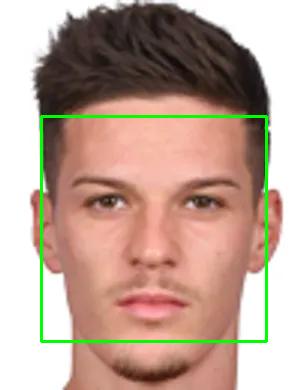

In [3]:
face_cascade = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# cv2.imshow('Facial Detection', img)
# cv2.waitKey(5000)  
# cv2.destroyAllWindows()

# convert image to png format and display in Jupyter notebook
ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

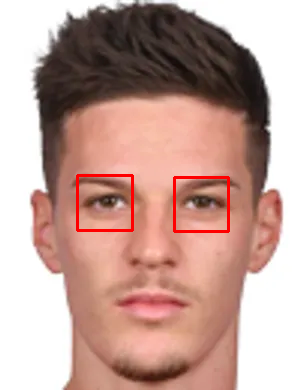

In [4]:
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in eyes:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
cv2.imshow('Eye Detection', img)
# cv2.waitKey(0)
# #time.sleep(5)
# cv2.destroyAllWindows()

ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

##### Instantiate just Face and Eye detection

In [ ]:
face_cascade = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")

### Eye detection on video stream

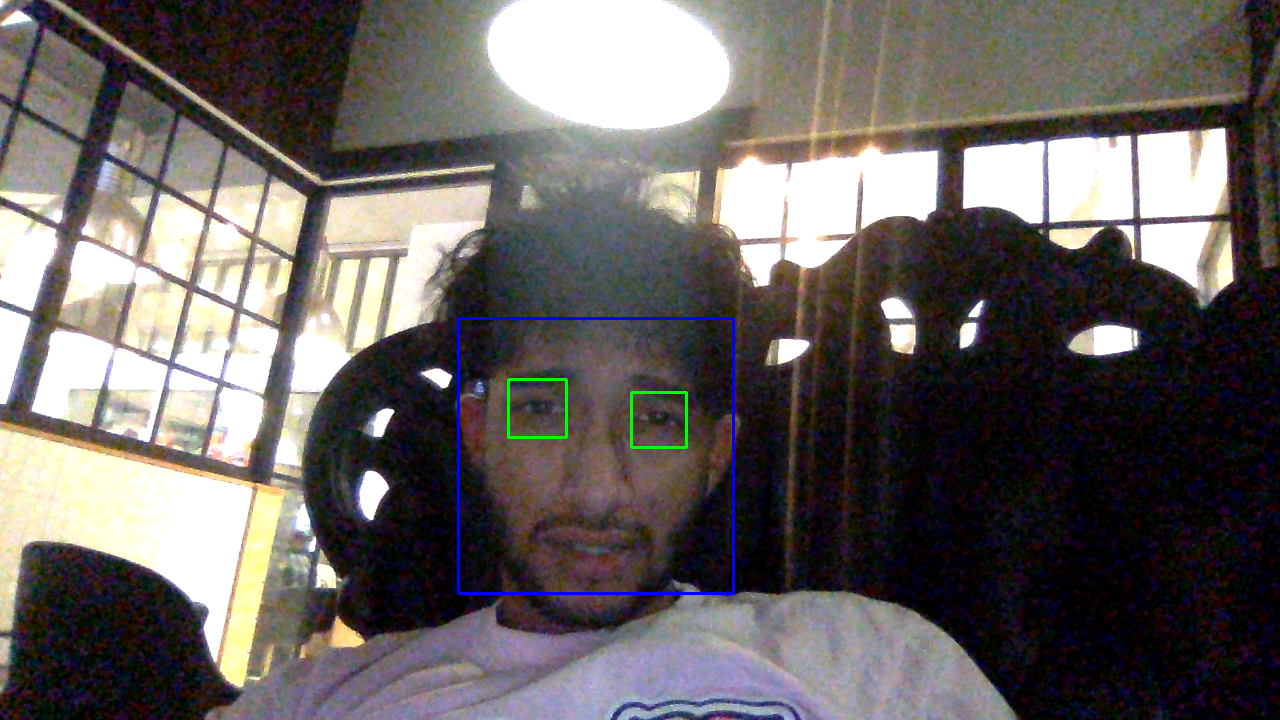

In [5]:
# Initialize the webcam
cap = cv2.VideoCapture(0)

# Set the maximum number of frames to display
max_frames = 100
frame_count = 0

while frame_count < max_frames:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale for better detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Extract the face region for eye detection
        face_gray = gray[y:y+h, x:x+w]
        face_color = frame[y:y+h, x:x+w]

        # Detect eyes in the face region
        eyes = eye_detector.detectMultiScale(face_gray)

        for (ex, ey, ew, eh) in eyes:
            # Draw a rectangle around the eyes
            cv2.rectangle(face_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

    # Encode the frame as a PNG image
    ret, buffer = cv2.imencode('.png', frame)
    io_buf = io.BytesIO(buffer)

    # Display the image in the notebook
    IPython.display.display(IPython.display.Image(data=io_buf.getvalue()))

    # Clear the output to update the display with the next frame
    clear_output(wait=True)
    
    # Increment the frame counter
    frame_count += 1
    
    # Control the frame rate (optional)
    time.sleep(0.1)

# Release the webcam
cap.release()


#### Now perform blob detection

Source: https://github.com/stepacool/Eye-Tracker/blob/master/project/capturers/haar_blob.py

In [35]:
def get_eyes(face):
    eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    left = None
    right = None
    
    if len(eyes) == 0:
        return None, None
    
    else:
        for (x, y, w, h) in eyes:
            # source: https://github.com/stepacool/Eye-Tracker/blob/master/project/capturers/haar_blob.py
            
            eye_center = int(float(x) + (float(w) / float(2))) 
            if int(face.shape[1] * 0.1) < eye_center < int(face.shape[1] * 0.4):
                left = face[y : y + h, x : x + w]
            elif int(face.shape[1] * 0.5) < eye_center < int(face.shape[1] * 0.9):
                right = face[y : y + h, x : x + w]
            else:
                pass  # false positive - nostrill
            
        return left, right
    

Test function on sample face

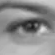

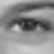

In [23]:
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

left, right = get_eyes(gray)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

ret, buffer = cv2.imencode('.png', right)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

We should probably get rid of eyebrows too

In [7]:
def no_eyebrows (eye):
    # get rid of the top 30 percent of the image of eyes so the only dark blobs are the pupils
    if eye is not None:
        eye = eye[int(eye.shape[0] * 0.2):, :]
        
    return eye

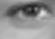

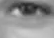

In [44]:
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

left, right = get_eyes(gray)

left = no_eyebrows(left)
right = no_eyebrows(right)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

ret, buffer = cv2.imencode('.png', right)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

In [17]:
def draw(img, blobs, dest=None):
    if dest is None:
        dest = img
    return cv2.drawKeypoints(
        img,
        blobs,
        dest,
        (0, 0, 255),
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    )


In [42]:
# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 15
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.87
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.blobColor = 255

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

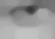

In [45]:
left = cv2.erode(left, None, iterations=2)
left = cv2.dilate(left, None, iterations=4)
left = cv2.medianBlur(left, 5)

# keypoints = detector.detect(left)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

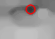

In [29]:
left_pupil = detector.detect(left)

left = draw(left, left_pupil)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

In [13]:
cap.release()

Account for the fact that we are drwaing directly onto the face now

In [37]:
def draw(img, blobs, eye_coordinates, dest=None): #
    if dest is None:
        dest = img

    for blob in blobs:
        x, y = eye_coordinates
        center = (int(blob.pt[0]) + x, int(blob.pt[1]) + y)
        radius = int(blob.size / 2)
        cv2.circle(dest, center, radius, (0, 0, 255), 2)

    return dest


Practice this drwaing function in the original picture of the man

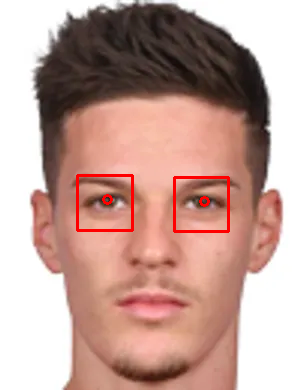

In [40]:
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in eyes:
    
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    left, right = get_eyes(gray)

    left = cv2.erode(left, None, iterations=2)
    left = cv2.dilate(left, None, iterations=4)
    left = cv2.medianBlur(left, 5)

    left_pupil = detector.detect(left)

    img = draw(img, left_pupil, (x, y))
    
cv2.imshow('Eye Detection', img)
# cv2.waitKey(0)
# #time.sleep(5)
# cv2.destroyAllWindows()

left, right = get_eyes(gray)

left = cv2.erode(left, None, iterations=2)
left = cv2.dilate(left, None, iterations=4)
left = cv2.medianBlur(left, 5)

left_pupil = detector.detect(left)

img = draw(img, left_pupil, (x, y))

ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

In [46]:
# lowering thresholds to detect pupils in dark environments

# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 15
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.87
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.blobColor = 255

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

In [47]:
# Initialize the webcam
cap = cv2.VideoCapture(0)

# Set the maximum number of frames to display
max_frames = 25
frame_count = 0

while frame_count < max_frames:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale for better detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Extract the face region for eye detection
        face_gray = gray[y:y+h, x:x+w]
        
        # applying histogram equalization to enhance the contrast of the grayscale image:
        face_gray = cv2.equalizeHist(face_gray)

        face_color = frame[y:y+h, x:x+w]

        # Detect eyes in the face region
        eyes = eye_detector.detectMultiScale(face_gray)

        for (ex, ey, ew, eh) in eyes:
            # Draw a rectangle around the eyes
            cv2.rectangle(face_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
            
            # Get the left and right eyes using the get_eyes function
            left, right = get_eyes(face_gray)


            if left is not None:
                left_no_eyebrows = no_eyebrows(left)
                if left_no_eyebrows.size > 0:
                    left_processed = cv2.erode(left_no_eyebrows, None, iterations=1)
                    left_processed = cv2.dilate(left_processed, None, iterations=3)
                    left_processed = cv2.medianBlur(left_processed, 5)
                    left_blobs = detector.detect(left_processed)
                    draw(face_color, left_blobs, (x, y))

            if right is not None:
                right_no_eyebrows = no_eyebrows(right)
                if right_no_eyebrows.size > 0:
                    right_processed = cv2.erode(right_no_eyebrows, None, iterations=1)
                    right_processed = cv2.dilate(right_processed, None, iterations=3)
                    right_processed = cv2.medianBlur(right_processed, 5)
                    right_blobs = detector.detect(right_processed)
                    draw(face_color, right_blobs, (x, y))

            

    # Encode the frame as a PNG image
    ret, buffer = cv2.imencode('.png', frame)
    io_buf = io.BytesIO(buffer)

    # Display the image in the notebook
    IPython.display.display(IPython.display.Image(data=io_buf.getvalue()))

    # Clear the output to update the display with the next frame
    clear_output(wait=True)
    
    # Increment the frame counter
    frame_count += 1
    
    # Control the frame rate (optional)
    time.sleep(0.1)

# Release the webcam
cap.release()


error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/morph.dispatch.cpp:1010: error: (-215:Assertion failed) !src.empty() in function 'erode'
